In [1]:
%load_ext autoreload
%autoreload 2
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, Concatenate, TimeDistributed, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.model_selection import train_test_split
import numpy as np
from helper_funcs import gen_samples
from scipy.fft import rfftfreq
import pickle
import matplotlib.pyplot as plt

In [2]:
# First navigate to our directory
transfer_directory_path = os.path.join("Data", "synth_transfer_df.parquet")
general_directory_path = os.path.join("Data", "synth_general_df.parquet")
# Load the dataframes
synth_transfer_df = pd.read_parquet(transfer_directory_path)
synth_general_df = pd.read_parquet(general_directory_path)
# Concatenate (after making sure they share columns) and then reset indices
assert list(synth_transfer_df.columns) == list(synth_general_df.columns), "Column names do not match!"
df = pd.concat([synth_transfer_df, synth_general_df], axis=0)
df.reset_index(drop=True, inplace=True)

In [3]:
# Split into train (70%) and temp (30%) with stratification
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['species'],  # Stratify based on the 'species' column
    random_state=42
)

# Split temp into test (15%) and validation (15%)
test_df, val_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['species'],  # Stratify again to maintain balance
    random_state=42
)

In [ ]:
# Prepare samples
print("Generating Training Samples")
X_train, y_train, mins_maxes_train, isolated_peaks_train = gen_samples(train_df)
print("Generating Test Samples")
X_test, y_test, mins_maxes_test, isolated_peaks_test = gen_samples(test_df)
print("Generating Validation Samples")
X_val, y_val, mins_maxes_val, isolated_peaks_val = gen_samples(val_df)

Generating Training Samples


In [ ]:
y_train = y_train[:, :, 0]
y_test = y_test[:, :, 0]
y_val = y_val[:, :, 0]

In [ ]:


def weight_func(prom, k=3, peak_encourage=10):
    return peak_encourage*((prom/k)**k) / (1 + (prom/k)**k)

def custom_loss(y_true, y_pred):
    """
    Custom loss function for (batch_size, N):
    - Binary cross-entropy for the output node.
    - Each bin in each sample is weighted by f(SNR), where SNR is the 3rd node label.
    
    Args:
    y_true: Tensor of true labels, shape (batch_size, N, 3).
    y_pred: Tensor of predicted values, shape (batch_size, N, 3).
    
    Returns:
    A scalar tensor representing the combined loss.
    """

    # Check for any negative values or values greater than 1 in y_true
    has_negative_y_true = tf.reduce_any(y_true < 0)
    has_greater_one_y_true = tf.reduce_any(y_true > 1)
    
    # Check for any negative values in y_pred
    has_negative_y_pred = tf.reduce_any(y_pred < 0)
    
    # Use tf.debugging.assert_* to enforce conditions during graph execution
    tf.debugging.assert_equal(
        has_negative_y_true, False, message="y_true contains negative values."
    )
    tf.debugging.assert_equal(
        has_greater_one_y_true, False, message="y_true contains values greater than 1."
    )
    tf.debugging.assert_equal(
        has_negative_y_pred, False, message="y_pred contains negative values."
    )
    # # Manually calculate binary cross-entropy for the first node
    # epsilon = 1e-7  # Small constant to prevent log(0)
    # y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    # bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # # Weighting each bin by weight_func(prom), where prominence is the 3rd node label
    # prom = y_true[..., 2]  # prom is the 3rd node label, shape (batch_size, N)
    # weights = tf.where(prom < 0, tf.ones_like(prom), weight_func(snr))  # If prom < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func
    
    # Use Keras's built-in binary cross-entropy loss
    bce = BinaryCrossentropy(reduction='none')  # No reduction so we can weight the loss per sample
    
    # Compute binary cross-entropy loss for the first node
    bce_loss = bce(y_true[..., 0], y_pred[..., 0])  # Shape (batch_size, N)

    # Weighting each bin by weight_func(prom), where prominence is the 3rd node label
    prom = y_true[..., 2]  # prom is the 3rd node label, shape (batch_size, N)

    weights = tf.where(prom < 0, tf.ones_like(prom), weight_func(prom))  # If prom < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func
    
    # Apply weights to the BCE loss
    weighted_bce_loss = bce_loss * weights  # Shape (batch_size, N)


    # Sum BCE losses across bins (N) for each sample
    mean_bce_loss_per_sample = tf.reduce_sum(weighted_bce_loss, axis=1, keepdims=False)

    # Combine and average across the batch
    total_loss = tf.reduce_mean(mean_bce_loss_per_sample)  # Mean over batch size

    return total_loss



def peak_counting_error(isolated_peaks_val, val_predictions):
    M = isolated_peaks_val.shape[0] # Number of samples
    assert M == val_predictions.shape[0], "Mismatch in number of samples!"
    best_error = 10000  # Initial large value for minimizing error
    best_thresh = None
    for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
        current_error = 0
        val_predictions_snapped = (val_predictions > thresh).astype(int)
        
        for row in range(M):
            predictions_row = val_predictions_snapped[row, :]
            isolated_labels_row = isolated_peaks_val[row, :]
            
            # We want to go along the predictions row, and find continuous chunks of 1s and 0s.
            # Every time a chunk ends, we then check how many peaks were truly in that chunk (by counting the 1s in those indices in isolated_labels_row)
            # We then add the square of the differences between the predicted number of peaks and the actual number of peaks to total_error
            # The predicted number of peaks in a chunk of 1s is always 1, and the predicted number of peaks in a chunk of 0s is always 0.
            
            # Track the current chunk
            current_chunk_value = predictions_row[0]
            current_chunk_start = 0

            for idx in range(1, len(predictions_row) + 1):  # +1 to handle the last chunk
                if idx == len(predictions_row) or predictions_row[idx] != current_chunk_value:
                    # Chunk ends here
                    chunk_end = idx
                    chunk_labels = isolated_labels_row[current_chunk_start:chunk_end]
                    
                    # Predicted peaks for this chunk
                    predicted_peaks = current_chunk_value
                    # Actual peaks for this chunk
                    actual_peaks = int(chunk_labels.sum())  # Count the 1s in the chunk
                    
                    # Add squared error to total_error
                    current_error += (predicted_peaks - actual_peaks) ** 2
                    
                    # Start a new chunk
                    current_chunk_value = predictions_row[idx] if idx < len(predictions_row) else None
                    current_chunk_start = idx
        
        current_error = current_error / M
        print(f"Peak counting error for threshold {thresh}: {current_error}")
        # Update the best threshold if this one performs better
        if current_error < best_error:
            best_error = current_error
            best_thresh = thresh
    
    print(f"Best threshold: {best_thresh}, Best Peak Counting Error: {best_error}")
    return best_error, best_thresh
        
class ValidationMetricCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, metric_name="peak_counting_error"):
        super(ValidationMetricCallback, self).__init__()
        self.validation_data = validation_data
        self.metric_name = metric_name

    def on_epoch_end(self, epoch, logs=None):
        val_x, (val_y, isolated_peaks_val) = self.validation_data  # Unpack extra labels
        val_predictions = self.model.predict(val_x, verbose=0)
        
        M = isolated_peaks_val.shape[0] # Number of samples
        assert M == val_predictions.shape[0], "Mismatch in number of samples!"
        best_error = 10000  # Initial large value for minimizing error
        best_thresh = None
        for thresh in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
            current_error = 0
            val_predictions_snapped = (val_predictions > thresh).astype(int)
            
            for row in range(M):
                predictions_row = val_predictions_snapped[row, :]
                isolated_labels_row = isolated_peaks_val[row, :]
                
                # We want to go along the predictions row, and find continuous chunks of 1s and 0s.
                # Every time a chunk ends, we then check how many peaks were truly in that chunk (by counting the 1s in those indices in isolated_labels_row)
                # We then add the square of the differences between the predicted number of peaks and the actual number of peaks to total_error
                # The predicted number of peaks in a chunk of 1s is always 1, and the predicted number of peaks in a chunk of 0s is always 0.
                
                # Track the current chunk
                current_chunk_value = predictions_row[0]
                current_chunk_start = 0

                for idx in range(1, len(predictions_row) + 1):  # +1 to handle the last chunk
                    if idx == len(predictions_row) or predictions_row[idx] != current_chunk_value:
                        # Chunk ends here
                        chunk_end = idx
                        chunk_labels = isolated_labels_row[current_chunk_start:chunk_end]
                        
                        # Predicted peaks for this chunk
                        predicted_peaks = current_chunk_value
                        # Actual peaks for this chunk
                        actual_peaks = int(chunk_labels.sum())  # Count the 1s in the chunk
                        
                        # Add squared error to total_error
                        current_error += (predicted_peaks - actual_peaks) ** 2
                        
                        # Start a new chunk
                        current_chunk_value = predictions_row[idx] if idx < len(predictions_row) else None
                        current_chunk_start = idx
            
            current_error = current_error / M
            print(f"Peak counting error for threshold {thresh}: {current_error}")
            # Update the best threshold if this one performs better
            if current_error < best_error:
                best_error = current_error
                best_thresh = thresh
        
        print(f"Best threshold: {best_thresh}, Best Peak Counting Error: {best_error}")
        peak_counting_error = best_error
        # Add the validation metric to logs
        logs[self.metric_name] = peak_counting_error.numpy()

        print(f"Epoch {epoch + 1}: {self.metric_name} = {peak_counting_error.numpy()}")

In [ ]:
# Define name for this model
model_version = "V1"

# Define the input length / number of frequency bins (N)
N = 8192

# Input layer
input_layer = Input(shape=(N, 1), name="Input")

# Inception-like layer with 1D convolutions
convs = []
# We'll base our kernel choices on the hwhm distribution of the peaks. 
# Thin peaks are in 3Hz-10Hz range --> 5-15 bins
# Wide peaks are in 10Hz-100Hz range --> 15-149 bins
# We choose filters at a range of scales, odd (to facilitate being cenetered around a peak)
# and we want more filters for the medium-small range since there are more peaks at this scale.
# Otherwise largely arbitrarily.
kernels = [(3, 4), (5, 8), (9, 16), (15, 32), (31, 32), (55, 32), (71, 16), (101, 8), (149, 4), (201, 2)]
for kernel_size, num_filters in kernels:
    convs.append(Conv1D(num_filters, kernel_size=kernel_size, activation='relu', padding='same', name=f"Conv_{kernel_size}")(input_layer))

# Concatenate the outputs of all convolutional layers
concat_layer = Concatenate(name="Inception_Concat")(convs)

# Time Distributed Dense Layers
td_dense64 = TimeDistributed(Dense(64, activation='relu'), name="Dense_64")(concat_layer)
td_dense32A = TimeDistributed(Dense(32, activation='relu'), name="Dense_32A")(td_dense64)
# bd_LSTM = Bidirectional(LSTM(16, return_sequences=True), name="LSTM")(td_dense32A)
# td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(bd_LSTM)
td_dense32B = TimeDistributed(Dense(32, activation='relu'), name="Dense_32B")(td_dense32A)
td_dense16 = TimeDistributed(Dense(16, activation='relu'), name="Dense_16")(td_dense32B)

# Final layer with 1 output per input bin
output = TimeDistributed(Dense(1, activation='sigmoid'), name="Output")(td_dense16)

# Define the model
model = Model(inputs=input_layer, outputs=output, name=model_version)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy')

# Summary
# model.summary()


In [ ]:
# Define batch size, number of epochs, and patience
batch_size = 32
epochs = 5
patience = 3

model_path = os.path.join("PP Model", f"{model_version}.keras")



# Add callbacks for better training
callbacks = [
    ValidationMetricCallback(validation_data=(X_val, (y_val, isolated_peaks_val)), metric_name="peak_counting_error"),
    EarlyStopping(monitor="peak_counting_error", patience=patience, restore_best_weights=True, verbose=1),  # Stop if no improvement for 5 epochs
    ModelCheckpoint(model_path, save_best_only=True, monitor='peak_counting_error')  # Save the best model
]



# Train the model
history = model.fit(
    X_train,                # Training data
    y_train,                # Training labels
    validation_data=(X_val, y_val),  # Validation data
    epochs=epochs,        # Number of epochs
    batch_size=batch_size,  # Batch size
    callbacks=callbacks,    # Add callbacks for early stopping and checkpointing
    verbose=1               # Verbose output
)

with open(f'{model_version}_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

Epoch 1/5
169/169 [==============================] - 186s 1s/step - loss: 0.3425 - val_loss: 0.1133
Epoch 2/5
169/169 [==============================] - 185s 1s/step - loss: 0.1116 - val_loss: 0.1126
Epoch 3/5
169/169 [==============================] - 190s 1s/step - loss: 0.1115 - val_loss: 0.1126
Epoch 4/5
169/169 [==============================] - 188s 1s/step - loss: 0.1115 - val_loss: 0.1127
Epoch 5/5
169/169 [==============================] - 189s 1s/step - loss: 0.1115 - val_loss: 0.1126


In [ ]:
# model_version = "V1"
model = load_model(os.path.join("PP Model", f"{model_version}.keras"))

In [28]:
# Assuming the predicted values are probabilities from 0 to 1
val_pred = model.predict(X_val)  # Predicted probabilities or binary values


37/37 [==============================] - 5s 137ms/step


In [ ]:
best_error, best_thresh = peak_counting_error(isolated_peaks_val, val_pred)
sample_idx = 0
thresh = best_thresh
spectrum = X_val[sample_idx, :]
predicted_peaks = val_pred[sample_idx, :]  # Assuming it's binary (0s and 1s)

# Frequency axis for the spectrum
f = rfftfreq(32768, 1/44100)[0:8192]

# Find indices where there are peaks (1 in predicted_peaks)
peak_indices = np.where(predicted_peaks > thresh)[0]

# Plot the spectrum
plt.plot(f, spectrum, label='Original Spectrum')

# Plot the peaks as scatter points
plt.scatter(f[peak_indices], spectrum[peak_indices], color='red', label='Predicted Peaks')

# Add labels and legend
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Peak counting error for threshold 0.1: [437.33391154]
Peak counting error for threshold 0.2: [437.33391154]
Peak counting error for threshold 0.3: [437.33391154]


In [ ]:
# Get validation counting accuracy
val_peak_counting_accuracy = peak_counting_accuracy(isolated_peaks_val, val_pred)

print("Test Loss:", test_loss)


In [ ]:
""""""""""""""""""""""""""""""""""""""""""""""""

In [ ]:
# Verify Custom Loss
# Example data: batch_size=4, N=5, nodes=3
y_true = np.array([
    [[0, 0.5, 0.7], [0, 0.2, -1], [0, 10000, -1000], [0, 0.3, 10], [0, 0.1, 10]],  # Sample 1
    [[0, 0.6, 0.3], [1, 0.1, -1], [1, 0.3, 10], [0, 0.4, 10], [0, 0.7, 10]],  # Sample 2
    [[0, 0.4, 1.5], [1, 0.8, -1], [1, 0.6, 10], [1, 0.2, 10], [0, 0.9, 10]],  # Sample 3
    [[0, 0.5, 0.6], [0, 0.3, -1], [0, 0.7, 10], [1, 0.1, 10], [0, 0.8, 10]],  # Sample 4
])

y_pred = np.array([
    [[0.9, 0.6, 0.8], [0.9, 0.3, 0.5], [0.5, 100000, 1000], [0.7, 0.4, 0.6], [0.2, 0.1, 0.3]],  # Sample 1
    [[0.7, 0.5, 0.4], [0.9, 0.2, 0.3], [0.9, 0.4, 0.6], [0.6, 0.7, 0.9], [0.8, 0.7, 0.8]],  # Sample 2
    [[0.8, 0.4, 0.5], [0.9, 0.6, 0.8], [0.9, 0.7, 0.5], [0.9, 0.3, 0.6], [0.2, 0.9, 0.7]],  # Sample 3
    [[0.9, 0.4, 0.3], [0.9, 0.6, 0.8], [0.6, 0.9, 0.7], [0.9, 0.3, 0.5], [0.8, 0.7, 0.6]],  # Sample 4
])

# Convert to tensors
y_true_tensor = tf.convert_to_tensor(y_true, dtype=tf.float32)
y_pred_tensor = tf.convert_to_tensor(y_pred, dtype=tf.float32)

loss_value = custom_loss(y_true_tensor, y_pred_tensor)
print("Loss Value:", loss_value.numpy())

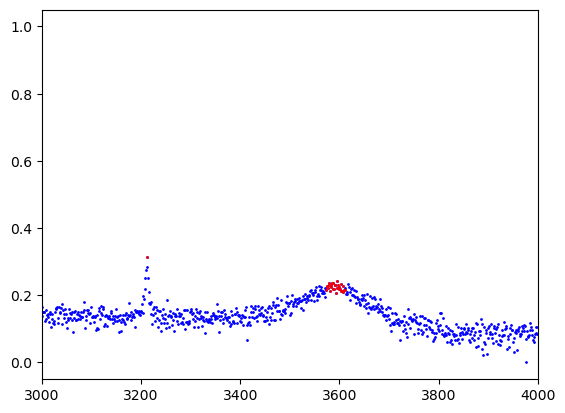

In [56]:
# Plot a sample
i = 1
spectrum = X_train[i]
f = rfftfreq(32768, 1/44100)[0:8192]

labels = y_train[i, :, :]
spread_peak_labels = labels[:, 0]
indices = np.where(spread_peak_labels == 1)[0]
# isolated_peaks = isolated_peaks_train[i]
# indices = np.where(isolated_peaks == 1)[0]
plt.scatter(f, spectrum, color='blue', s=1)
plt.scatter(f[indices], spectrum[indices], color='red', s=1)
plt.xlim(3000, 4000)
plt.show()

In [ ]:
# Verify peak_counting_error
isolated_peaks_val=np.array(
    [[0, 1, 0, 0, 1], 
     [1, 0, 1, 0, 0]]
    )
val_predictions=np.array(
    [[0.81, 0.91, 0.71, 0.31, 0.91],
     [0.81, 0.21, 0.91, 0.96, 0.91]]
    )

peak_counting_error(isolated_peaks_val, val_predictions)

In [ ]:
# Figure out how many bins our peaks are
f = rfftfreq(32768, 1/44100)
# HWFM (in bins) of a peak with a HWHM of 100Hz
bin_width = f[1] - f[0]
print(f"HWFM (in bins) of a peak with a HWHM of 100Hz: {200 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 10Hz: {20 / bin_width}")
print(f"HWFM (in bins) of a peak with a HWHM of 3Hz: {6 / bin_width}")

In [ ]:
# def custom_loss(y_true, y_pred):
#     """
#     Custom loss function for (batch_size, N, 3):
#     - Binary cross-entropy for the first output node.
#     - MSE for the second and third output nodes, masked by the first node's true labels.
#     - Each bin in each sample is weighted by f(SNR), where SNR is the 3rd node label.
    
#     Args:
#     y_true: Tensor of true labels, shape (batch_size, N, 3).
#     y_pred: Tensor of predicted values, shape (batch_size, N, 3).
    
#     Returns:
#     A scalar tensor representing the combined loss.
#     """

    # # Mean squared error for the second and third nodes
    # mse_loss_2 = tf.square(y_true[..., 1] - y_pred[..., 1])
    # mse_loss_3 = tf.square(y_true[..., 2] - y_pred[..., 2])
    # mse_loss = mse_loss_2 + mse_loss_3  # Shape (batch_size, N)

    # # Mask the MSE loss where the first node's true label is 0
    # mask = tf.cast(y_true[..., 0] > 0, tf.float32)  # Shape (batch_size, N)
    # masked_mse_loss = mse_loss * mask  # Shape (batch_size, N)
    
    # # Manually calculate binary cross-entropy for the first node
    # epsilon = 1e-7  # Small constant to prevent log(0)
    # y_pred_clipped = tf.clip_by_value(y_pred[..., 0], epsilon, 1.0 - epsilon)
    # bce_loss = -(y_true[..., 0] * tf.math.log(y_pred_clipped) + (1 - y_true[..., 0]) * tf.math.log(1 - y_pred_clipped))  # Shape (batch_size, N)

    # # Weighting each bin by weight_func(SNR), where SNR is the 3rd node label
    # snr = y_true[..., 2]  # SNR is the 3rd node label, shape (batch_size, N)
    # weights = tf.where(snr < 0, tf.ones_like(snr), weight_func(snr))  # If SNR < 0, weight is 1 (fully weight the BCE loss for non-peak bins), else apply weight_func

    # # Apply weights to the masked MSE loss
    # weighted_mse_loss = masked_mse_loss * weights  # Shape (batch_size, N)
    
    # # Apply weights to the BCE loss
    # weighted_bce_loss = bce_loss * weights  # Shape (batch_size, N)

    # # Average weighted MSE, BCE losses across bins (N) for each sample
    # mean_mse_loss_per_sample = tf.reduce_mean(weighted_mse_loss, axis=1)  # Mean over N for shape (batch_size,)
    # mean_bce_loss_per_sample = tf.reduce_mean(weighted_bce_loss, axis=1)

    # # Combine and average across the batch
    # total_loss = tf.reduce_mean(mean_bce_loss_per_sample + mean_mse_loss_per_sample)  # Mean over batch size

    # return total_loss




# class ValidationMetricCallback(tf.keras.callbacks.Callback):
#     def __init__(self, validation_data, metric_name="peak_counting_error"):
#         super(ValidationMetricCallback, self).__init__()
#         self.validation_data = validation_data
#         self.metric_name = metric_name

#     def on_epoch_end(self, epoch, logs=None):
#         val_x, (val_y, isolated_peaks_val) = self.validation_data  # Unpack extra labels
#         val_predictions = self.model.predict(val_x, verbose=0)
        
#         # Compute your custom metric (e.g., Mean Absolute Error)
#         val_metric = peak_counting_error(isolated_peaks_val, val_predictions)

#         # Add the validation metric to logs
#         logs[self.metric_name] = val_metric.numpy()

#         print(f"Epoch {epoch + 1}: {self.metric_name} = {val_metric.numpy()}")


# for row_idx in range(y_train.shape[0]):
#     y_peak_labels = y_train[:, :, 0]
#     if tf.reduce_any(y_peak_labels[row_idx] < 0):  # Check if any value in the row is negative
#         print(f"Row {row_idx} contains negative values:")
#         print(y_peak_labels[row_idx])
